In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.validators.scatter.marker import SymbolValidator
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

import plotly.offline as pyo
pyo.init_notebook_mode()

import re
from wordcloud import WordCloud
import nltk
import string
from nltk.corpus import stopwords
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

df =pd.read_csv("vaccination_tweets.csv")
df.drop(["id","user_created"],axis=1,inplace=True)
df['date'] = pd.to_datetime(df['date'],format='%d/%m/%y %H:%M')
df.head(5)

user_name              user_location  \
0            Rachel Roh  La Crescenta-Montrose, CA   
1           Albert Fong          San Francisco, CA   
2              eli🇱🇹🇪🇺👌                   Your Bed   
3         Charles Adler     Vancouver, BC - Canada   
4  Citizen News Channel                        NaN   

                                    user_description  user_followers  \
0  Aggregator of Asian American news; scanning di...             405   
1  Marketing dude, tech geek, heavy metal & '80s ...             834   
2                                     heil, hydra 🖐☺              10   
3  Hosting "CharlesAdlerTonight" Global News Radi...           49165   
4  Citizen News Channel bringing you an alternati...             152   

   user_friends  user_favourites  user_verified                date  \
0          1692             3247          False 2020-12-20 06:06:00   
1           666              178          False 2020-12-13 16:27:00   
2            88              155          False 2020-12-12 20:33:00   
3          3933            21853           True 2020-12-12 20:23:00   
4           580             1473          False 2020-12-12 20:17:00   

                                                text  \
0  Same folks said daikon paste could treat a cyt...   
1  While the world has been on the wrong side of ...   
2  #coronavirus #SputnikV #AstraZeneca #PfizerBio...   
3  Facts are immutable, Senator, even when you're...   
4  Explain to me again why we need a vaccine @Bor...   

                                            hashtags               source  \
0                                 ['PfizerBioNTech']  Twitter for Android   
1                                                NaN      Twitter Web App   
2  ['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...  Twitter for Android   
3                                                NaN      Twitter Web App   
4     ['whereareallthesickpeople', 'PfizerBioNTech']   Twitter for iPhone   

   retweets  favorites  is_retweet  
0         0          0       False  
1         1          1       False  
2         0          0       False  
3       446       2129       False  
4         0          0       False

In [2]:
px.histogram(df, x="date",nbins=100,opacity=1,title="Tweets Num TimeSeries", template="simple_white")

In [3]:
source = pd.DataFrame(df.groupby("source")["user_name"].count())
source.reset_index(inplace=True)
source.columns=["source","count"]

fig = px.bar(source[source["count"]>5],x="source",y="count",color="source",text="count",
             title="Tweets Source",opacity=0.5, template="simple_white")
fig.update_traces(textposition='outside')
fig.show()

### sentiment analysis

In [4]:
import re
import random
import math
from tqdm.notebook import tqdm
from collections import Counter
import pandas as pd

from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt 

import wordninja
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from nltk.stem import WordNetLemmatizer
#from nltk.corpus import stopwords 
#stop_words = set(stopwords.words('english'))  
#stop_words.add("amp")

In [5]:
data = pd.read_csv("vaccination_tweets.csv")
data['date'] = pd.to_datetime(data['date'],format='%d/%m/%y %H:%M')
# data contains one non-string entry for 'text'
str_mask = [isinstance(x, str) for x in data.text]
data = data[str_mask]

In [6]:
# standard tweet preprocessing 

data.text =data.text.str.lower()
#Remove twitter handlers
data.text = data.text.apply(lambda x:re.sub('@[^\s]+','',x))
#remove hashtags
data.text = data.text.apply(lambda x:re.sub(r'\B#\S+','',x))
# Remove URLS
data.text = data.text.apply(lambda x:re.sub(r"http\S+", "", x))
# Remove all the special characters
data.text = data.text.apply(lambda x:' '.join(re.findall(r'\w+', x)))
#remove all single characters
data.text = data.text.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

data.text = data.text.apply(lambda x:re.sub("covidvaccine|vaccine|covid|Pfizer|pfizer|biontech|pfizerbiontech|coronavirus|coronavirusvaccine|covid19vaccine",'',x))

# Substituting multiple spaces with single space
data.text = data.text.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
# Convert string to a list of words
data['words'] = data.text.apply(lambda x:re.findall(r'\w+', x ))

In [7]:
def get_sign(x, p, n):
    if x > p:
        return 1
    if x < n:
        return -1 
    return 0

def flatten_list(l):
    return [x for y in l for x in y]

In [8]:
sia = SIA()

sentiments = [sia.polarity_scores(x)['compound'] for x in tqdm(data['text'])]
classes = [get_sign(s, 0.35, -0.05) for s in sentiments]
data['classes'] = classes

In [9]:
with open("stopwords_EN.txt", 'r') as f:
    stop_words = f.read().split("\n")
def is_acceptable(word: str):
    return word not in stop_words and len(word) > 2

In [10]:
# Create one document each for all words in the negative, neutral and  positive classes respectively
neg_doc = flatten_list(data[data['classes'] == -1]['words'])
neg_doc = [x for x in neg_doc if is_acceptable(x)]

pos_doc = flatten_list(data[data['classes'] == +1]['words'])
pos_doc = [x for x in pos_doc if is_acceptable(x)]

neu_doc = flatten_list(data[data['classes'] == 0]['words'])
neu_doc = [x for x in neu_doc if is_acceptable(x)]

In [11]:
# color coding our wordclouds 
def red_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(0, 100%, {random.randint(25, 75)}%)" 

def green_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl({random.randint(90, 150)}, 100%, 30%)" 

def yellow_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return f"hsl(42, 100%, {random.randint(25, 50)}%)" 

In [12]:
# reusable function to generate word clouds 
def generate_word_clouds(neg_doc, neu_doc, pos_doc):
    # Display the generated image:
    fig, axes = plt.subplots(1,3, figsize=(20,10))
    
    
    wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(neg_doc))
    axes[0].imshow(wordcloud_neg.recolor(color_func=red_color_func, random_state=3), interpolation='bilinear')
    axes[0].set_title("Negative Tweets")
    axes[0].axis("off")

    wordcloud_neu = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(neu_doc))
    axes[1].imshow(wordcloud_neu.recolor(color_func=yellow_color_func, random_state=3), interpolation='bilinear')
    axes[1].set_title("Neutral Words")
    axes[1].axis("off")

    wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(" ".join(pos_doc))
    axes[2].imshow(wordcloud_pos.recolor(color_func=green_color_func, random_state=3), interpolation='bilinear')
    axes[2].set_title("Positive Words")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show();

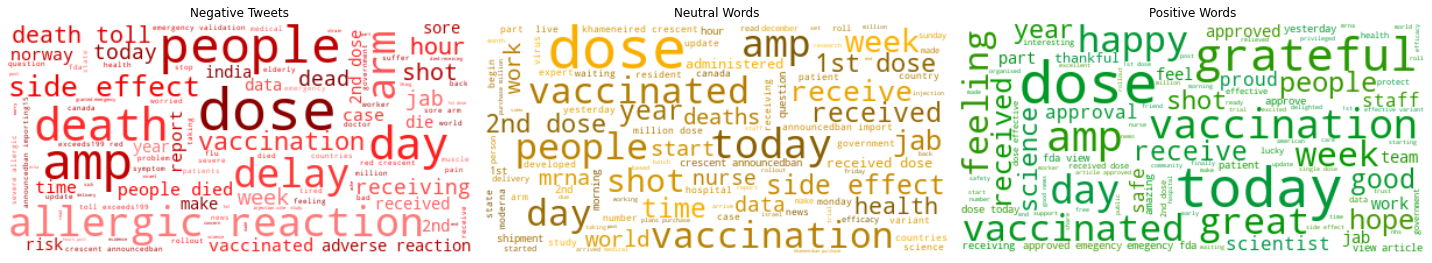

In [13]:
# Naive word clouds 
generate_word_clouds(neg_doc, neu_doc, pos_doc)

### Lexical dispersion plot

In [14]:
slt_df = df[['date','hashtags']].dropna().reset_index(drop=True)
slt_df.loc[:, 'hashtags'] = slt_df.dropna()['hashtags'].apply(lambda x: re.sub(r"\[|\]|'", '', x))

In [15]:
plot_df = slt_df.drop('hashtags', axis=1).join(
        slt_df['hashtags'].str.lower().str.split(', ', expand=True).\
    stack().reset_index(level=1, drop=True).rename('hashtags'))

cond = plot_df['hashtags'].isin("covid19|covid19vaccine|coronavirus|coronavirusvaccine|pfizercovidvaccine|covidvaccines|coronavaccine|covidvaccine|vaccine|covid|pfizer|biontech|pfizerbiontech|pfizervaccine".split("|"))
plot_df = plot_df[~cond]
word_cnt = plot_df['hashtags'].value_counts()

words_lst = plot_df['hashtags'].value_counts()[:30].index
plot_df = plot_df[plot_df['hashtags'].isin(words_lst)]

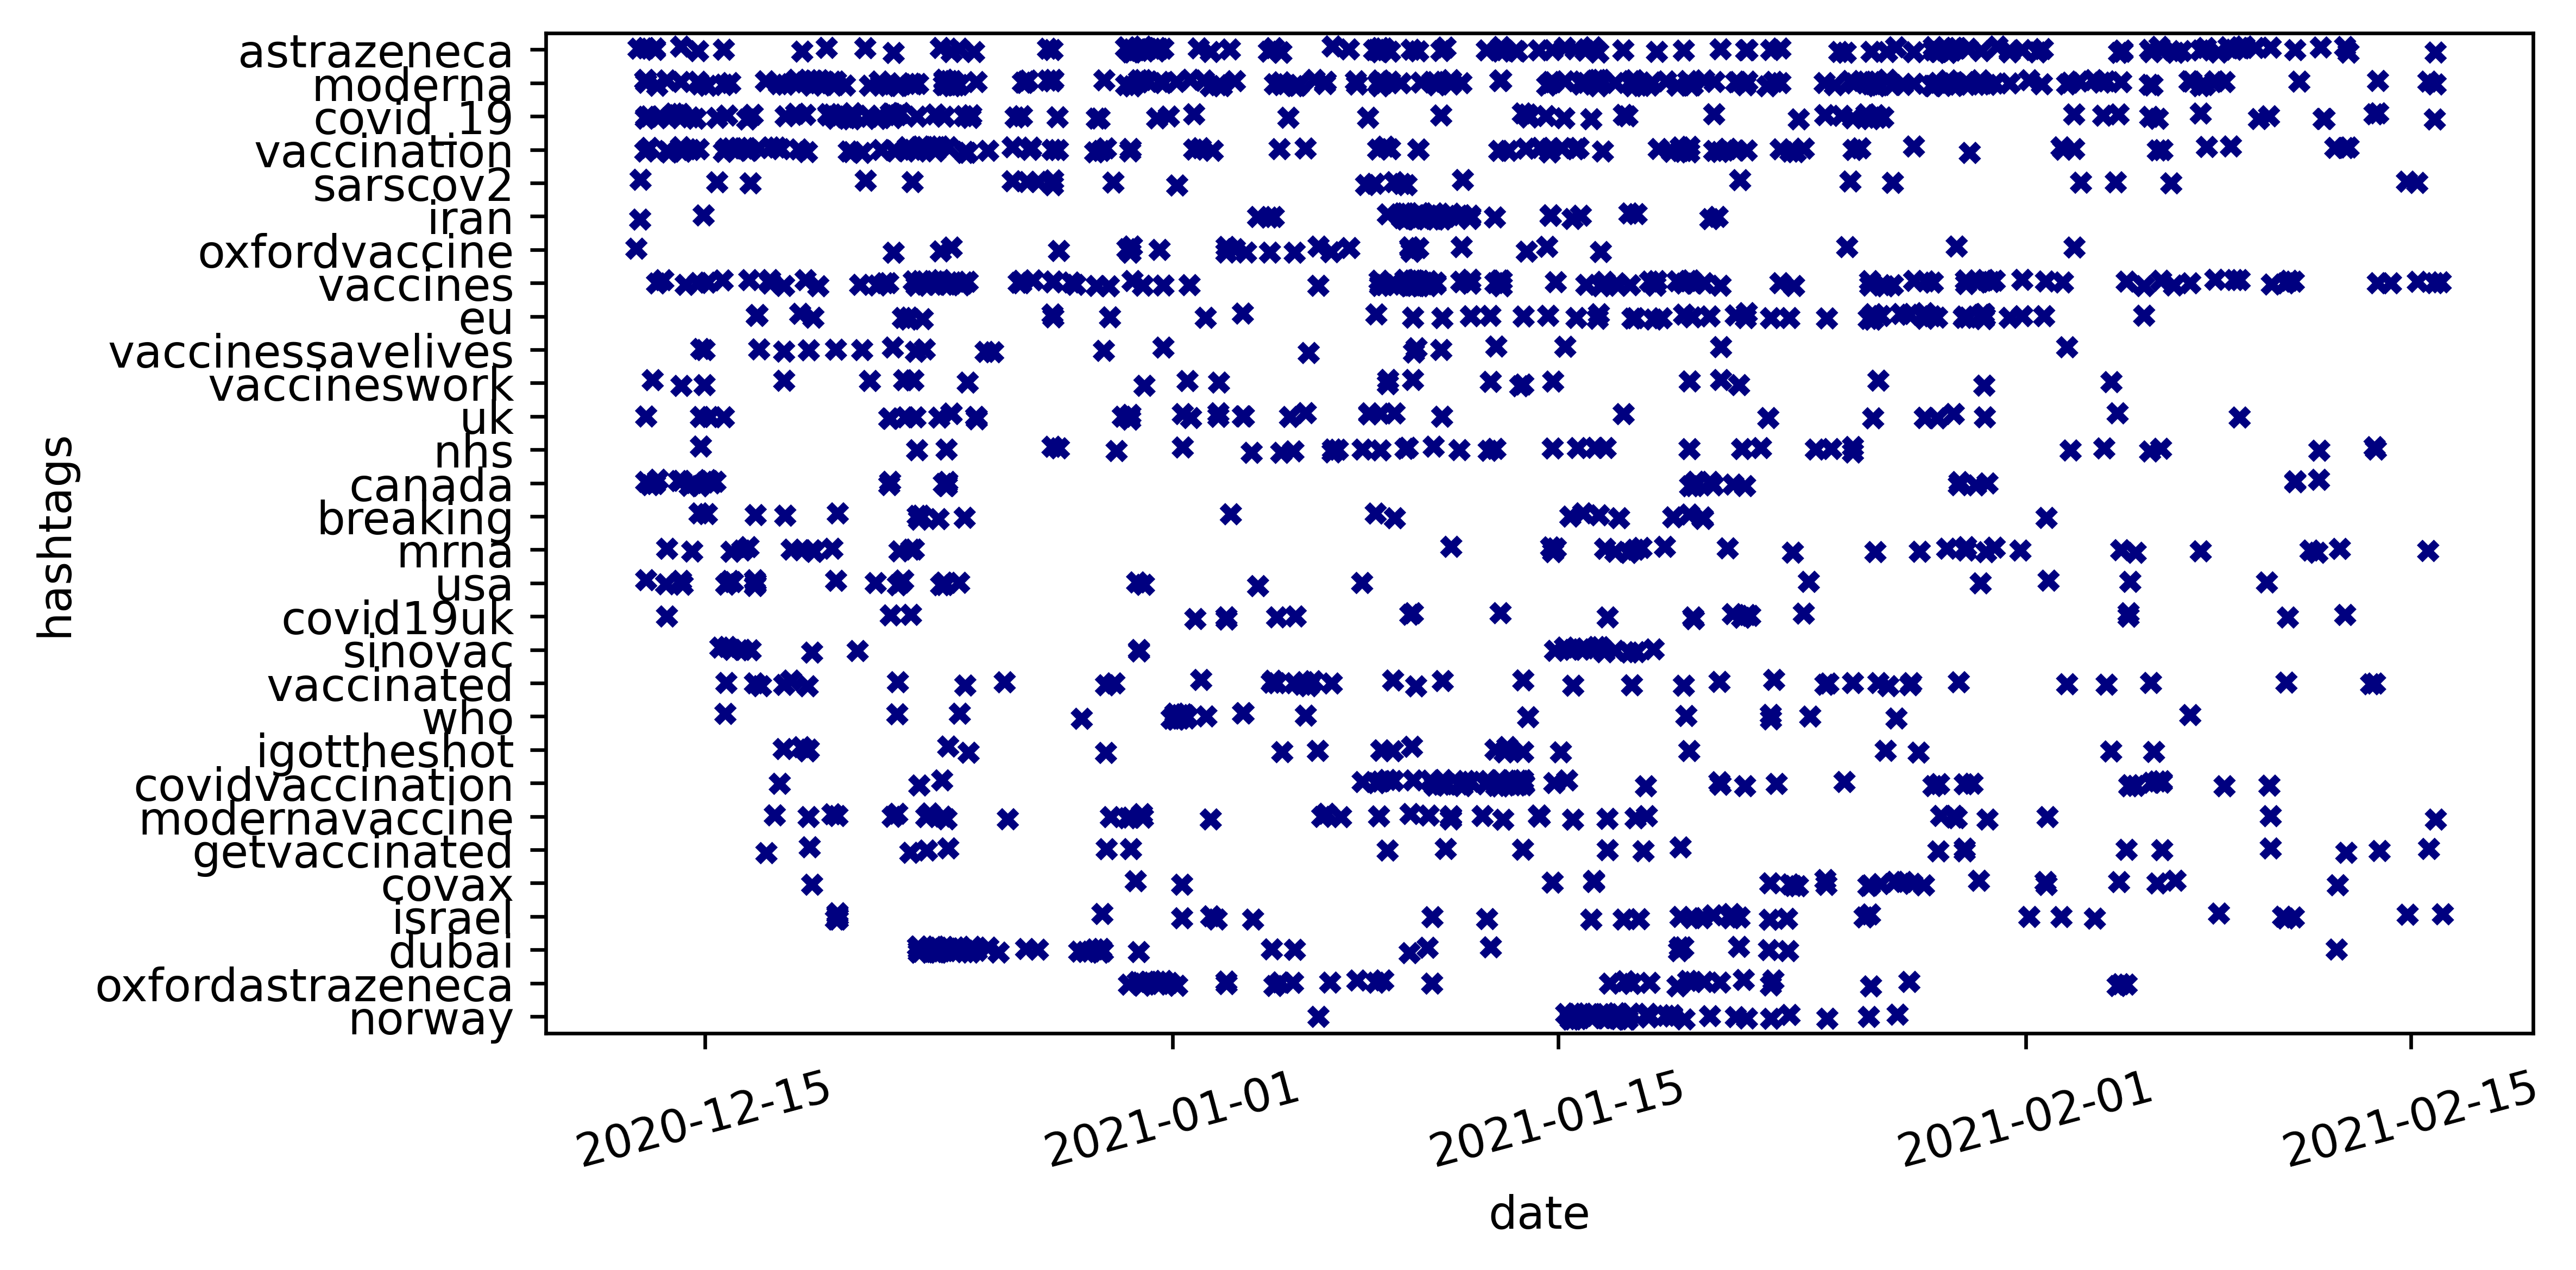

In [16]:
import seaborn as sns
plt.figure(figsize=(8,4), dpi=600)
sns.stripplot(y='hashtags',x='date', data=plot_df,
 orient='h', marker='X', color='navy', size=5)
# rotate x tick labels
plt.xticks(rotation=15)
# remover borders of plot
plt.tight_layout()
plt.show()

In [17]:
word_cnt[:30]

moderna              197
vaccines             138
astrazeneca          123
vaccination          106
covid_19              85
covidvaccination      62
eu                    61
iran                  60
dubai                 52
norway                44
vaccinated            44
modernavaccine        43
israel                41
mrna                  41
uk                    41
nhs                   39
oxfordastrazeneca     39
canada                35
usa                   31
who                   30
oxfordvaccine         30
covax                 26
sarscov2              26
vaccineswork          24
igottheshot           23
covid19uk             23
breaking              23
getvaccinated         22
sinovac               22
vaccinessavelives     22
Name: hashtags, dtype: int64